In [135]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

plt.style.use('fivethirtyeight')

In [132]:
import sqlite3
conn = sqlite3.connect("stock.sqlite")
query = "select * from stock_table_d where `ticker` == 'AAPL' and datetime > '2012-01-01' and datetime < '2023-01-01'"
df = pd.read_sql(query,conn)
df['Date'] = pd.to_datetime(df['Datetime'])
df.set_index(df['Date'],inplace = True)
df.drop('Date', inplace=True,axis=1)
df

,Datetime,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,,
2013-02-13,2013-02-13 00:00:00,16.686071,16.915714,16.543571,16.678928,14.405273,475207600,AAPL
2013-02-14,2013-02-14 00:00:00,16.590000,16.844286,16.572144,16.663929,14.392323,355275200,AAPL
2013-02-15,2013-02-15 00:00:00,16.744642,16.791430,16.425714,16.434286,14.193980,391745200,AAPL
2013-02-19,2013-02-19 00:00:00,16.467857,16.526072,16.208929,16.428213,14.188737,435783600,AAPL
2013-02-20,2013-02-20 00:00:00,16.346071,16.346071,16.028570,16.030357,13.845119,476302400,AAPL
...,...,...,...,...,...,...,...,...
2022-12-23,2022-12-23 00:00:00,130.919998,132.419998,129.639999,131.860001,131.658981,63814900,AAPL
2022-12-27,2022-12-27 00:00:00,131.380005,131.410004,128.720001,130.029999,129.831772,69007800,AAPL
2022-12-28,2022-12-28 00:00:00,129.669998,131.029999,125.870003,126.040001,125.847855,85438400,AAPL


In [113]:
df.shape

(2489, 9)

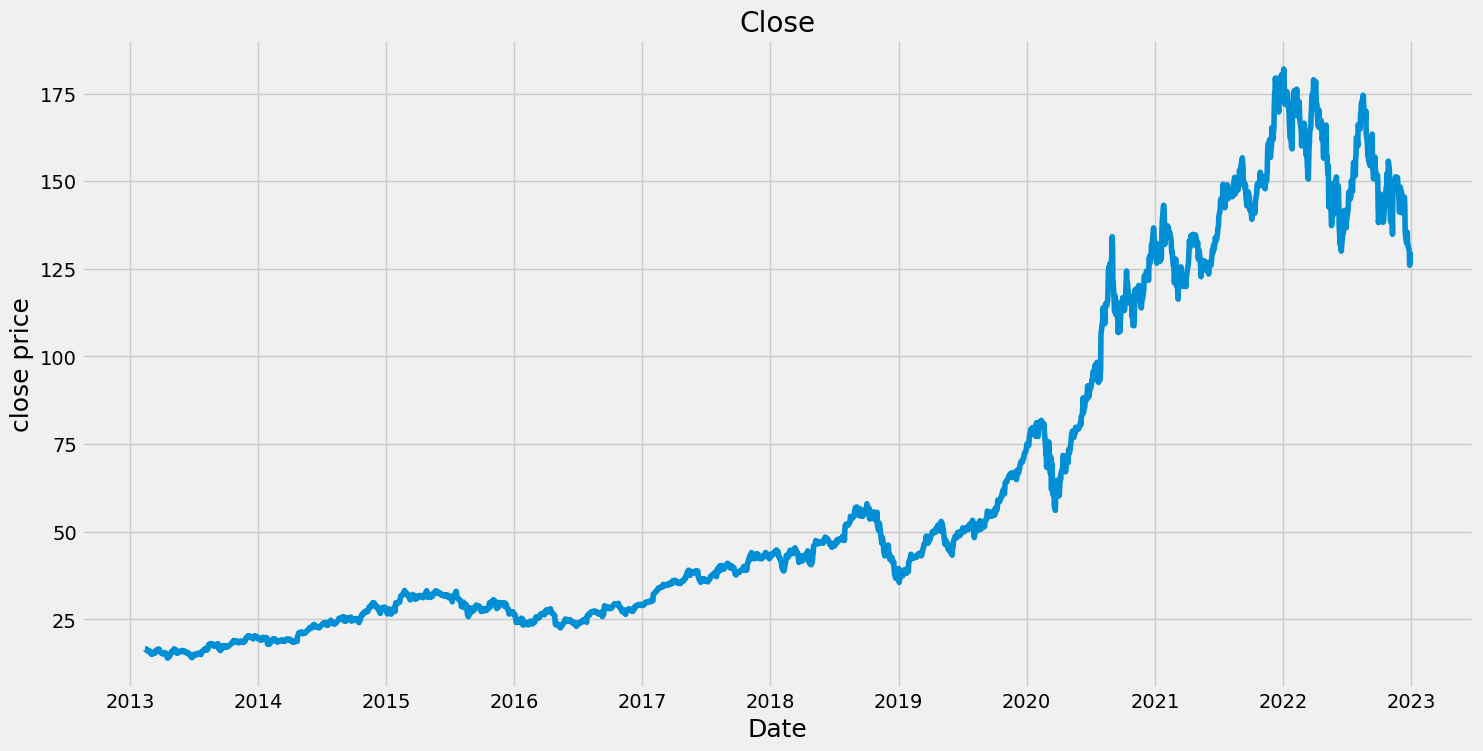

In [114]:
plt.figure(figsize=(16,8))
plt.title('Close')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('close price',fontsize=18)
plt.show()

In [115]:
# Create new dataframe with only close column
data = df.filter(['Close'])
# Convert the dataframe to numpy array
dataset = data.values
# Get number of row to train the model
trainning_data_len = math.ceil(len(dataset)*0.8)
trainning_data_len

1992

In [116]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01625246],
       [0.01616321],
       [0.01479679],
       ...,
       [0.66696916],
       [0.68821126],
       [0.69011526]])

In [117]:
# Create the training data set
# Create the scaled trainning data set 
train_data = scaled_data[0:trainning_data_len , :]
# Split the data into x_train and y_train dataset
x_train = []
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

[array([0.01625246, 0.01616321, 0.01479679, 0.01476066, 0.01239335,
       0.01180045, 0.01280986, 0.01110769, 0.01241885, 0.01148382,
       0.01081018, 0.00848749, 0.00627318, 0.00862986, 0.00746533,
       0.00851086, 0.00875312, 0.01006003, 0.00805397, 0.00803697,
       0.00891888, 0.01129044, 0.01385327, 0.01359189, 0.01307974,
       0.01321787, 0.01516868, 0.01552356, 0.01500505, 0.01307974,
       0.01107794, 0.00815598, 0.00834298, 0.0088105 , 0.00790309,
       0.00694257, 0.00758221, 0.00774584, 0.00959677, 0.00930777,
       0.00834511, 0.00623068, 0.00758859, 0.00260744, 0.00032301,
       0.        , 0.00172979, 0.0033151 , 0.00317271, 0.00379323,
       0.00566753, 0.00841311, 0.01110343, 0.01036179, 0.01168571,
       0.01263348, 0.01491368, 0.01447803, 0.01557881, 0.01407639])]
[0.013268870915054909]

[array([0.01625246, 0.01616321, 0.01479679, 0.01476066, 0.01239335,
       0.01180045, 0.01280986, 0.01110769, 0.01241885, 0.01148382,
       0.01081018, 0.00848749, 0.0

In [118]:
# Convert the x-train and y_train to numpy array
x_train,y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1932, 60, 1)

In [119]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [120]:
# Complie the model
model.compile(optimizer='adam', loss = 'mean_squared_error')

In [121]:
# Train the model
model.fit(x_train, y_train, batch_size=5, epochs=10)

Epoch 1/10
387/387 [==============================] - 24s 51ms/step - loss: 7.7992e-04
Epoch 2/10
387/387 [==============================] - 20s 51ms/step - loss: 2.4797e-04
Epoch 3/10
387/387 [==============================] - 21s 53ms/step - loss: 2.2448e-04
Epoch 4/10
387/387 [==============================] - 23s 59ms/step - loss: 2.0479e-04
Epoch 5/10
387/387 [==============================] - 22s 57ms/step - loss: 1.2200e-04
Epoch 6/10
387/387 [==============================] - 22s 57ms/step - loss: 1.4394e-04
Epoch 7/10
387/387 [==============================] - 22s 57ms/step - loss: 1.6970e-04
Epoch 8/10
387/387 [==============================] - 22s 56ms/step - loss: 1.1207e-04
Epoch 9/10
387/387 [==============================] - 21s 53ms/step - loss: 8.7951e-05
Epoch 10/10
387/387 [==============================] - 21s 53ms/step - loss: 1.0983e-04


In [122]:
# Create the testting data set
# Create a new array containing scaked value from index 1529 to 1986
test_data = scaled_data[trainning_data_len-60: , :]
# Create the data sets x _test and y_test
x_test = []
y_test = dataset[trainning_data_len:, :]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [123]:
# Convert a data to a numpy
x_test = np.array(x_test)

In [124]:
# Resahpe the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [125]:
# get the model predicted price value
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

16/16 [==============================] - 2s 19ms/step


In [126]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse

0.29348513873769966

C:\Users\jeng\AppData\Local\Temp\ipykernel_7452\2856079908.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


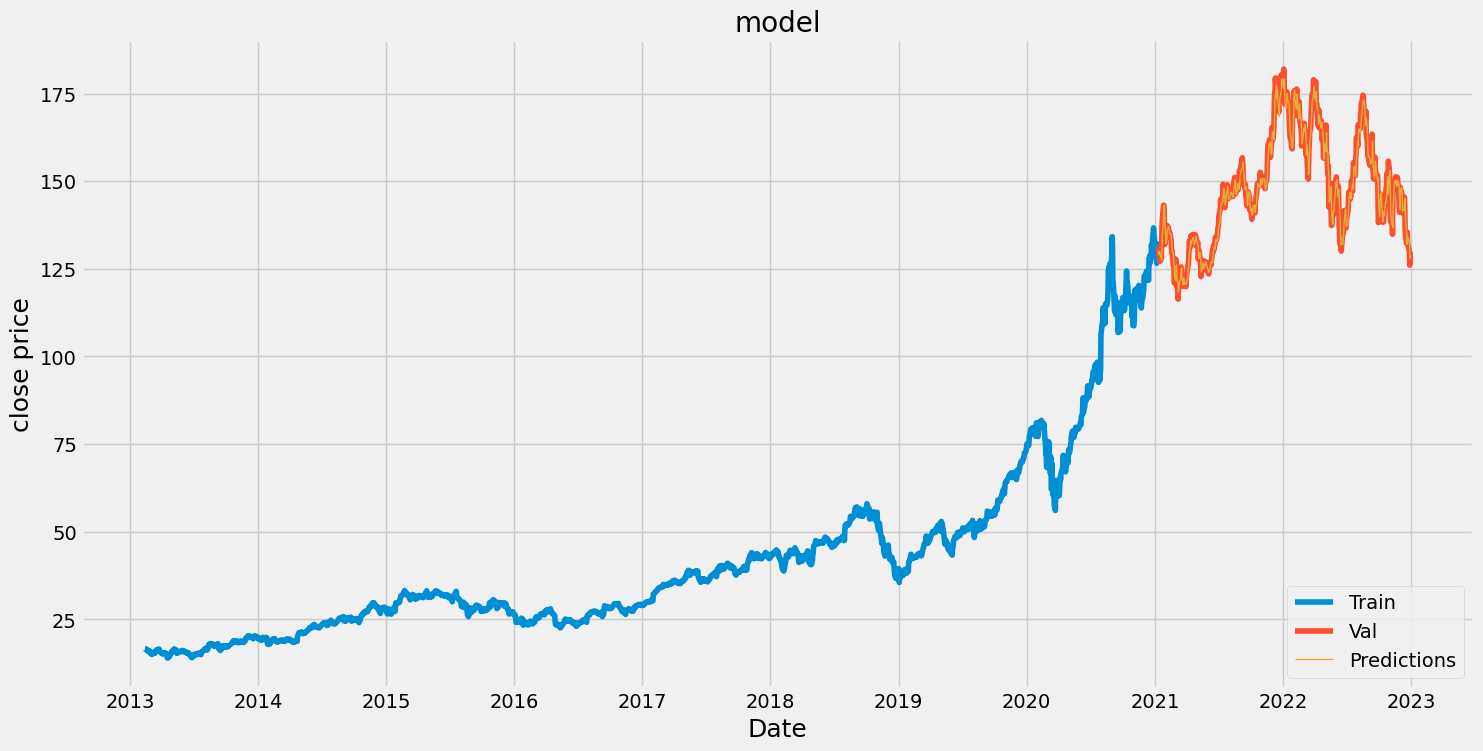

In [143]:
# plot data
train = data[:trainning_data_len]
valid = data[trainning_data_len:]
valid['Predictions'] = predictions
# visualize the data
plt.figure(figsize=(16,8))
plt.title('model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('close price',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close']])
plt.plot(valid[['Predictions']],lw=1)
plt.legend(['Train','Val','Predictions'],loc= 'lower right')
plt.show()

In [128]:
valid

,Close,Predictions
Date,,
2021-01-12,128.800003,130.093414
2021-01-13,130.889999,129.122482
2021-01-14,128.910004,129.926956
2021-01-15,127.139999,129.390366
2021-01-19,127.830002,127.869598
...,...,...
2022-12-23,131.860001,133.621765
2022-12-27,130.029999,132.774399
2022-12-28,126.040001,131.238388
